<a href="https://colab.research.google.com/github/aaravbmb/ML-speech-analysis-system/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Speech Analysis System

In [ ]:

import os
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshitapanwar2711","key":"9fda017559ec7e3426e7d7509afb5eaa"}'}

In [ ]:
import os
import zipfile

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess

Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-02-0

In [ ]:
def extract_mfcc(wav_file_name, n_mfcc=40):
    try:
        y, sr = librosa.load(wav_file_name, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {wav_file_name}: {e}")
        return None


In [ ]:
radvess_speech_labels = []
radvess_speech_data = []

for dirname, _, filenames in os.walk('/content/ravdess/'):
    for filename in filenames:
        if filename.endswith('.wav'):
            try:

                label = int(filename[6:8]) - 1
                wav_file_path = os.path.join(dirname, filename)

                mfcc = extract_mfcc(wav_file_path)
                if mfcc is not None:
                    radvess_speech_labels.append(label)
                    radvess_speech_data.append(mfcc)
            except Exception as e:
                print(f"Skipping file {filename} due to error: {e}")


In [ ]:
import numpy as np
import joblib
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

radvess_speech_data_array = np.array(radvess_speech_data)
radvess_speech_labels_array = np.array(radvess_speech_labels)

labels_categorical = to_categorical(radvess_speech_labels_array)

def add_noise(data, noise_level=0.02):
    return data + noise_level * np.random.randn(len(data))

def shift_time(data, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

augmented_data = [add_noise(x) for x in radvess_speech_data]
augmented_labels = labels_categorical.copy()

radvess_speech_data_array = np.concatenate((radvess_speech_data_array, np.array(augmented_data)))
labels_categorical = np.concatenate((labels_categorical, augmented_labels))

scaler = StandardScaler()
radvess_speech_data_array = scaler.fit_transform(radvess_speech_data_array)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    radvess_speech_data_array,
    labels_categorical,
    test_size=0.2,
    random_state=9,
    stratify=labels_categorical
)
x_train = np.expand_dims(x_train, axis=-1)        # Shape: (samples, 40, 1)
x_train = np.repeat(x_train, 2, axis=-1)          # Shape: (samples, 40, 2)

x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 2, axis=-1)

print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

number_of_samples = radvess_speech_data_array.shape[0]
training_samples = x_train.shape[0]
test_samples = x_test.shape[0]
validation_samples = int(number_of_samples * 0.1)


Training set shape: (4608, 40, 2)
Testing set shape: (1152, 40, 2)
Training labels shape: (4608, 8)
Testing labels shape: (1152, 8)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(40, 2)))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_A = create_model_LSTM()
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
history = model_A.fit(
    x_train,
    y_train,
    validation_split=0.1,
    epochs=130,
    shuffle=True,
    callbacks=[lr_reduction],
    batch_size=32
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1566 - loss: 2.0462 - val_accuracy: 0.2234 - val_loss: 1.9165 - learning_rate: 5.0000e-04
Epoch 2/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2444 - loss: 1.9412 - val_accuracy: 0.3015 - val_loss: 1.8316 - learning_rate: 5.0000e-04
Epoch 3/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2712 - loss: 1.8653 - val_accuracy: 0.2950 - val_loss: 1.7977 - learning_rate: 5.0000e-04
Epoch 4/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3017 - loss: 1.8239 - val_accuracy: 0.2928 - val_loss: 1.7902 - learning_rate: 5.0000e-04
Epoch 5/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2985 - loss: 1.8123 - val_accuracy: 0.3124 - val_loss: 1.7685 - learning_rate: 5.0000e-04
Epoch 6/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3004 - loss: 1.7957 - val_accuracy: 0.3384 - val_loss: 1.7472 - learning_rate: 5.0000e-04
Epoch 7/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a

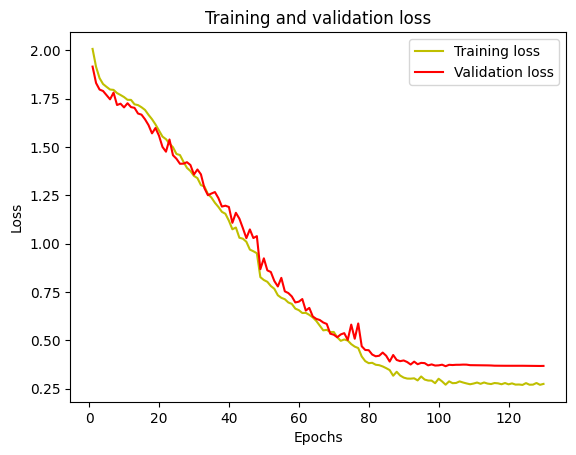

In [ ]:
# Loss Plot for LSTM Model
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

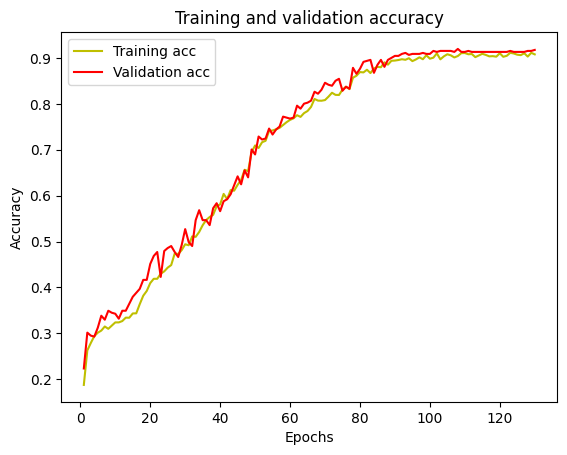

In [ ]:
# Accuracy Plots using LSTM Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

✅ Model Accuracy on Test Set: 96.53%

📋 Classification Report:
              precision    recall  f1-score   support

     neutral       0.93      1.00      0.96        38
        calm       1.00      1.00      1.00        76
       happy       0.95      0.93      0.94        75
         sad       0.99      0.95      0.97        77
       angry       0.99      0.96      0.97        78
     fearful       0.91      0.97      0.94        77
     disgust       0.95      0.96      0.96        78
   surprised       1.00      0.96      0.98        77

    accuracy                           0.97       576
   macro avg       0.96      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



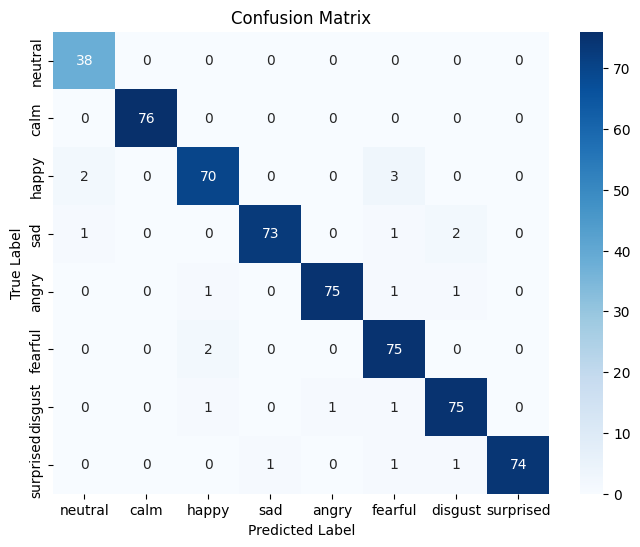

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

emotions = {
    0: "neutral", 1: "calm", 2: "happy", 3: "sad",
    4: "angry", 5: "fearful", 6: "disgust", 7: "surprised"
}

x_test_eval = np.expand_dims(radvess_speech_data_array[training_samples+validation_samples:], -1)
x_test_eval = np.repeat(x_test_eval, 2, axis=-1)
y_pred = model_A.predict(x_test_eval)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_categorical[training_samples+validation_samples:], axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\n✅ Model Accuracy on Test Set: {accuracy * 100:.2f}%")

print("\n📋 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotions.values()))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions.values(), yticklabels=emotions.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def predict(wav_filepath):
    test_point = extract_mfcc(wav_filepath)
    test_point = np.array(test_point).reshape(1, -1)
    test_point = scaler.transform(test_point)
    test_point = np.expand_dims(test_point, -1)
    test_point = np.repeat(test_point, 2, axis=-1)
    predictions = model_A.predict(test_point)
    predicted_label = np.argmax(predictions[0])
    predicted_emotion = emotions[predicted_label]

    print(f"🧠 Predicted Emotion: {predicted_emotion}")


In [ ]:
predict('/content/ravdess/Actor_12/03-01-01-01-02-01-12.wav')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
🧠 Predicted Emotion: calm


In [ ]:
model_A.save('emotionrecognition.h5')
print("Model successfully saved as 'emotionrecognition.h5'!")

Model successfully saved as 'emotionrecognition.h5'!
